# Multi-Armed Bandit Algorithms
This notebook implements and compares:
- Thompson Sampling
- UCB (Upper Confidence Bound)
- Softmax Exploration
- Pure Exploration (`ε=1`)
- Pure Exploitation (`ε=0`)



In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Bandit:
    def __init__(self, probabilities):
        self.probabilities = probabilities  # True probabilities of winning for each arm
        self.n_arms = len(probabilities)

    def pull(self, arm):
        # Simulate pulling an arm
        return 1 if np.random.rand() < self.probabilities[arm] else 0


In [5]:
# Define the policies
class ThompsonSampling:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)
        self.failures = np.zeros(n_arms)

    def select_arm(self):
        samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.n_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

In [6]:
class Softmax:
    def __init__(self, n_arms, temperature=0.1):
        self.n_arms = n_arms
        self.temperature = temperature
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        exp_values = np.exp(self.values / self.temperature)
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        # Update estimated value using incremental formula
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

In [7]:
class UCB:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0

    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + np.sqrt(2 * np.log(self.total_counts) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_counts += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

In [8]:
# Define pure exploration and pure exploitation policies
class PureExploration:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)

    def select_arm(self):
        # Select the arm with the least pulls
        return np.argmin(self.counts)

    def update(self, arm, reward):
        self.counts[arm] += 1

In [9]:
class PureExploitation:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        # Select the arm with the highest estimated value
        if np.sum(self.counts) == 0:
            return np.random.randint(self.n_arms)
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

In [10]:
# Simulation function

def simulate(bandit, policy, n_rounds):
    rewards = np.zeros(n_rounds)
    for t in range(n_rounds):
        arm = policy.select_arm()
        reward = bandit.pull(arm)
        policy.update(arm, reward)
        rewards[t] = reward
    return rewards

In [11]:
# Parameters
np.random.seed(42)
probabilities = [0.1, 0.5, 0.8]  # True probabilities of each arm
n_rounds = 10000

# Initialize bandit
bandit = Bandit(probabilities)

# Initialize policies
policies = {
    "Thompson Sampling": ThompsonSampling(len(probabilities)),
    "Softmax": Softmax(len(probabilities)),
    "UCB": UCB(len(probabilities)),
    "Pure Exploration": PureExploration(len(probabilities)),
    "Pure Exploitation": PureExploitation(len(probabilities))
}

In [12]:
# Run simulations
results = {}
for name, policy in policies.items():
    rewards = simulate(bandit, policy, n_rounds)
    results[name] = rewards.cumsum()  # Cumulative rewards

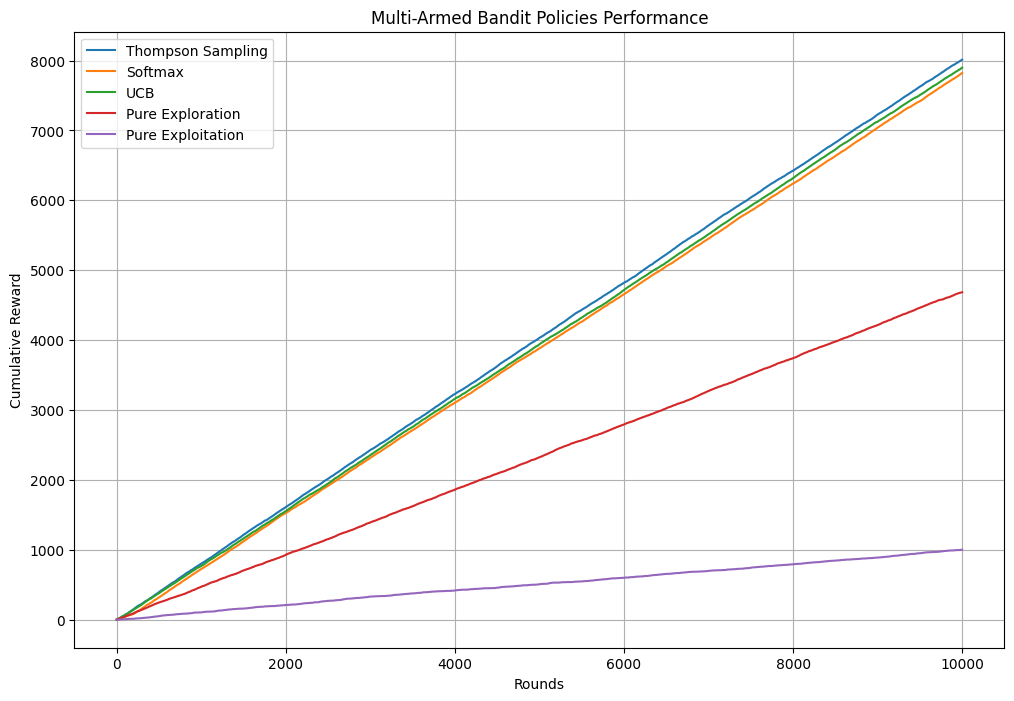

In [13]:
# Plot results
plt.figure(figsize=(12, 8))
for name, rewards in results.items():
    plt.plot(rewards, label=name)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Multi-Armed Bandit Policies Performance')
plt.legend()
plt.grid(True)
plt.show()